## Agent With Parallel Execution:
- Async nodes.

**Imports**

In [52]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

import asyncio

**Agent State:**

In [53]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], lambda x, y: x + y]  # <-- Combine lists
    validation_message: str
    payment_message: str
    inventory_message: str

**Node Function:**

In [54]:
async def receive_order(state: AgentState) -> AgentState:
    print("🟢 Receiving order...")
    await asyncio.sleep(0.1)
    msg = AIMessage(content="Order received.")
    return {
        "messages": [msg]
    }

async def validate_order(state: AgentState) -> AgentState:
    print("🔍 Validating order...")
    await asyncio.sleep(0.2)
    return {
        "messages": [AIMessage(content="Order validated.")]
    }    

async def check_inventory(state: AgentState) -> AgentState:
    print("📦 Checking inventory...")
    await asyncio.sleep(1)  # Simulate I/O
    return {
        'inventory_message': 'Item available in inventory',
        'messages': [AIMessage(content="Inventory available.")]
    }

async def check_payment(state: AgentState) -> AgentState:
    print("💳 Verifying payment...")
    await asyncio.sleep(1.5)  # Simulate payment API delay
    return {
        "messages": [AIMessage(content="Payment successful.")],
        "payment_message": "Payment successful."
    }

async def finalize_order(state: AgentState) -> AgentState:
    print("📋 Finalizing order...")
    await asyncio.sleep(0.3)
    return {
        "messages": [AIMessage(content="Order finalized.")],
        "validation_message": state["inventory_message"] + " " + state["payment_message"]
    }

async def send_confirmation(state: AgentState) -> AgentState:
    print("📨 Sending confirmation...")
    await asyncio.sleep(0.2)
    return {
        "messages": [AIMessage(content="Confirmation sent.")]
    }

**Build Graph:**

In [55]:
graph = StateGraph(AgentState)

graph.add_node("Receive Order", receive_order)
graph.add_node("Validate Order", validate_order)
graph.add_node("Check Inventory", check_inventory)
graph.add_node("Check Payment", check_payment)
graph.add_node("Finalize Order", finalize_order)
graph.add_node("Send Confirmation", send_confirmation)

# Define parallel flow
graph.set_entry_point("Receive Order")

graph.add_edge("Receive Order", "Validate Order")

# map
graph.add_edge("Validate Order", "Check Inventory")
graph.add_edge("Validate Order", "Check Payment")

# reduce
graph.add_edge("Check Inventory", "Finalize Order")
graph.add_edge("Check Payment", "Finalize Order")

# finalize
graph.add_edge("Finalize Order", "Send Confirmation")

graph.set_finish_point("Send Confirmation")

**Compile Graph And Invoke:**

In [56]:
agent = graph.compile()

# For notebook/interactive environment
state = {
    'inventory_message': '',
    'payment_message': '',
    'validation_message': '',
    'messages': []
}

result = await agent.ainvoke(state)

print("\n\n")
print("Inventory Message => ", result["inventory_message"])
print("Payment Message => ", result["payment_message"])
print("Validation Message => ", result["validation_message"])

🟢 Receiving order...
🔍 Validating order...
📦 Checking inventory...
💳 Verifying payment...
📋 Finalizing order...
📨 Sending confirmation...



Inventory Message =>  Item available in inventory
Payment Message =>  Payment successful.
Validation Message =>  Item available in inventory Payment successful.


**Agent Graph:**

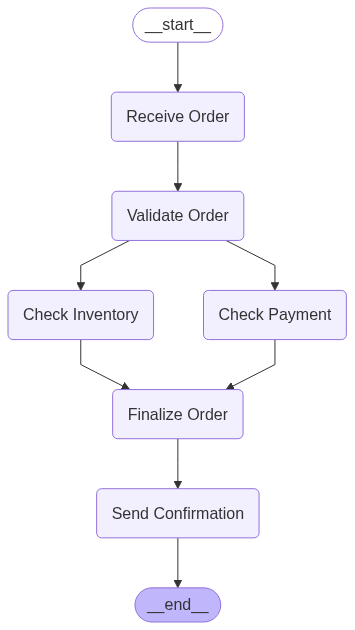

In [57]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))